### 데이터셋
* 허깅페이스 데이터셋 처음 사용하기

In [1]:
from huggingface_hub import list_datasets

In [2]:
all_datasets = [ds.id for ds in list_datasets()]

In [3]:
len(all_datasets), all_datasets[:10]

(181957,
 ['amirveyseh/acronym_identification',
  'ade-benchmark-corpus/ade_corpus_v2',
  'UCLNLP/adversarial_qa',
  'Yale-LILY/aeslc',
  'nwu-ctext/afrikaans_ner_corpus',
  'fancyzhx/ag_news',
  'allenai/ai2_arc',
  'google/air_dialogue',
  'komari6/ajgt_twitter_ar',
  'legacy-datasets/allegro_reviews'])

In [4]:
# emotion 데이터셋 로드
from datasets import load_dataset
emotion = load_dataset('emotion')

C:\Users\knuyh\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [5]:
emotion

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [6]:
train_set = emotion['train']
train_set[0]

{'text': 'i didnt feel humiliated', 'label': 0}

In [7]:
train_set.features

{'text': Value(dtype='string', id=None),
 'label': ClassLabel(names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}

* 데이터셋에서 데이터프레임으로

In [8]:
emotion.set_format(type = 'pandas') # 출력 포맷 변경
df = emotion['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [9]:
def label_int2str(row):
    return emotion["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


* 클래스 분포 살펴보기

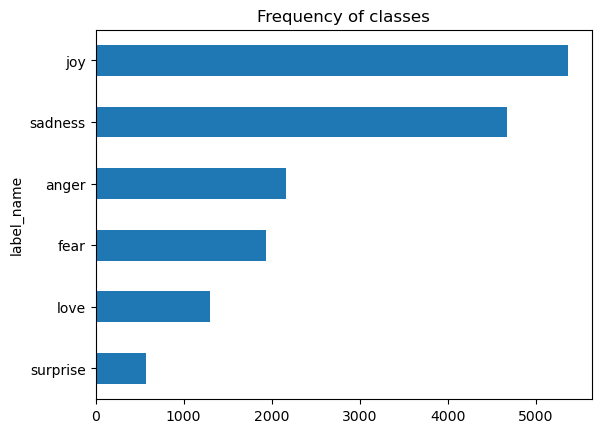

In [10]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending = True).plot.barh()
plt.title('Frequency of classes')
plt.show()

심각한 데이터 불균형  
-> 해결 방법(3)
   * 소수 클래스 랜덤하게 오버샘플링
   * 다수 클래스 랜덤하게 언더샘플링
   * 클래스의 대표성 부족하면, 레이블된 데이터 더 많이 수집하기

* 트윗 길이 확인

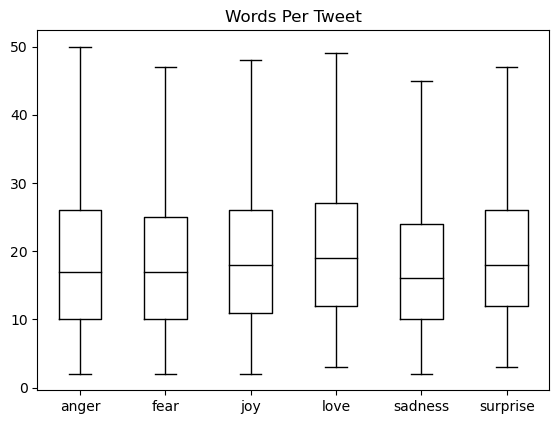

In [11]:
# 토큰 = text의 기본 단위
df["Words Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False, showfliers=False,
           color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

각 감정의 트윗 길이는 15개 단어 정도  
가장 긴 트윗도 DistilBERT의 최대 문맥 크기(512)보다 작다.

In [12]:
# 데이터셋 출력 포맷 초기화
emotion.reset_format()

### 텍스트에서 토큰으로
- DistilBERT 같은 트랜스포머 모델은 원시 문자열을 입력으로 받지 못한다. 텍스트가 토큰화되어 수치 벡터로 인코딩됐다고 가정
- 토큰화 : 문자열을 모델이 사용하는 기본 단위로 분할

* 문자 토큰화

In [13]:
text = 'Tokenizing text is a core task of NLP.'
tokenized_text = list(text)
print(tokenized_text)

['T', 'o', 'k', 'e', 'n', 'i', 'z', 'i', 'n', 'g', ' ', 't', 'e', 'x', 't', ' ', 'i', 's', ' ', 'a', ' ', 'c', 'o', 'r', 'e', ' ', 't', 'a', 's', 'k', ' ', 'o', 'f', ' ', 'N', 'L', 'P', '.']


In [14]:
token2idx = {ch : idx for idx, ch in enumerate(sorted(set(tokenized_text)))}
print(token2idx)

{' ': 0, '.': 1, 'L': 2, 'N': 3, 'P': 4, 'T': 5, 'a': 6, 'c': 7, 'e': 8, 'f': 9, 'g': 10, 'i': 11, 'k': 12, 'n': 13, 'o': 14, 'r': 15, 's': 16, 't': 17, 'x': 18, 'z': 19}


In [15]:
input_ids = [token2idx[token] for token in tokenized_text]
print(input_ids)

[5, 14, 12, 8, 13, 11, 19, 11, 13, 10, 0, 17, 8, 18, 17, 0, 11, 16, 0, 6, 0, 7, 14, 15, 8, 0, 17, 6, 16, 12, 0, 14, 9, 0, 3, 2, 4, 1]


In [16]:
# 원 핫벡터의 2D텐서로 변경
import pandas as pd

categorical_df = pd.DataFrame(
    {"Name": ["Bumblebee", "Optimus Prime", "Megatron"], "Label ID": [0,1,2]})
categorical_df

,Name,Label ID
0,Bumblebee,0
1,Optimus Prime,1
2,Megatron,2


In [17]:
pd.get_dummies(categorical_df['Name'])

,Bumblebee,Megatron,Optimus Prime
0,True,False,False
1,False,False,True
2,False,True,False


In [18]:
import torch
import torch.nn.functional as F

In [19]:
input_ids = torch.tensor(input_ids)
one_hot_encodings = F.one_hot(input_ids, num_classes = len(token2idx))
one_hot_encodings.shape # 38개 입력 토큰 각각에 20차원

torch.Size([38, 20])

In [20]:
print(f"토큰: {tokenized_text[0]}")
print(f"텐서 인덱스: {input_ids[0]}")
print(f"원-핫 인코딩: {one_hot_encodings[0]}")

토큰: T
텐서 인덱스: 5
원-핫 인코딩: tensor([0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])


* 단어 토큰화

In [21]:
tokenized_text = text.split()
print(tokenized_text)

['Tokenizing', 'text', 'is', 'a', 'core', 'task', 'of', 'NLP.']


* 부분단어 토큰화
: 문자 토큰화 + 단어 토큰화

In [22]:
from transformers import AutoTokenizer

In [23]:
model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt) # 사전 훈련된 모델 로드

In [24]:
# 특정 클래스 수동으로도 로드 가능
from transformers import DistilBertTokenizer
distilbert_tokenizer = DistilBertTokenizer.from_pretrained(model_ckpt)

In [25]:
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 19204, 6026, 3793, 2003, 1037, 4563, 4708, 1997, 17953, 2361, 1012, 102], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [26]:
# 다시 토큰으로 변환
tokens = tokenizer.convert_ids_to_tokens(encoded_text.input_ids)
print(tokens)

['[CLS]', 'token', '##izing', 'text', 'is', 'a', 'core', 'task', 'of', 'nl', '##p', '.', '[SEP]']


체크 포인트의 특징
  * 소문자로 변환
  * 특수 토큰 [CLS], [SEP] 시작 끝 토큰 추가
  * tokenizing = token + ##izing : 자주 등장하지 않는 단어이기에 나뉨 (# : 앞의 문자열이 공백이 아님)

In [27]:
tokenizer.convert_tokens_to_string(tokens)

'[CLS] tokenizing text is a core task of nlp. [SEP]'

In [28]:
tokenizer.vocab_size, tokenizer.model_max_length # 어휘사전 크기, 모델의 최대 문맥 크기

(30522, 512)

In [29]:
tokenizer.model_input_names 

['input_ids', 'attention_mask']

* 전체 데이터셋 토큰화하기

In [30]:
def tokenize(batch) :
    return tokenizer(batch['text'], padding = True, truncation = True)
# padding = T : 배치에 있는 가장 긴 샘플 크기에 맞춰 샘플을 0으로 패딩
# truncation = T : 모델의 최대 문맥 크기에 맞춰 샘플 잘라냄

In [31]:
tokenize(emotion['train'][:2])

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}

input_ids의 첫번째 원소가 두번째보다 짧으므로 길이를 동일하게 하기 위해 끝에 0 추가  
어텐션 마스크 사용하면 모델이 입력에서 패딩된 부분 무시해도 된다.

In [32]:
tokens2ids = list(zip(tokenizer.all_special_tokens, tokenizer.all_special_ids))
data = sorted(tokens2ids, key=lambda x : x[-1])
df = pd.DataFrame(data, columns=["Special Token", "Special Token ID"])
df.T

,0,1,2,3,4
Special Token,[PAD],[UNK],[CLS],[SEP],[MASK]
Special Token ID,0,100,101,102,103


In [33]:
emotion_encoded = emotion.map(tokenize, batched = True, batch_size = None)
# batched = T : 트윗을 개별적으로 배치로 인코딩
# batch_size = None : 전체 데이터셋이 하나의 배치로

print(emotion_encoded['train'].column_names)

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

['text', 'label', 'input_ids', 'attention_mask']


### 텍스트 분류 모델 훈련하기
#### 트랜스포머를 특성 추출기로 사용하기
* 사전 훈련된 모델 사용하기

In [34]:
from transformers import AutoModel

In [35]:
model_ckpt = "distilbert-base-uncased"
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(model_ckpt)#.to(device)

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

C:\Users\knuyh\anaconda3\Lib\site-packages\huggingface_hub\file_download.py:157: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\knuyh\.cache\huggingface\hub\models--distilbert-base-uncased. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


* 마지막 은닉 상태 추출하기

In [ ]:
text = 'this is a test'
inputs = tokenizer(text, return_tensors = 'pt')
print(f'입력 텐서 크기 : {inputs['input_ids'].size()}')